# Homework3
Homework-3: Build a conditional VAE on CIFAR-10 that can generate images of 10 classes. Evaluate the performance of your VAE by (1) qualitative approach (i.e. manually inspecting and judging the generated images), and (2) quantitative approach using Inception Score (IS) and Fréchet Inception Distance (FID). Discuss your findings.

Note:
1. You should present information about your VAE including model architecture, number of parameters, and associated mechanisms.
2. For qualitative evaluation, you should present some generated images for each class.
3. For quantitative evaluation, you should generate 1,000 images for each class to make 10,000 generated images in total. Use the test batch (10,000 images) in CIFAR-10 as the set of real images, and calculate IS and FID of the generated images.

Ref. Image Generation on CIFAR-10 https://paperswithcode.com/sota/image-generation-on-cifar-10


https://github.com/alsdudrla10/DG

# 1. import需要的函示庫

In [1]:
!pip install tensorflow-probability
# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-y3fp_p_u
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-y3fp_p_u
  Resolved https://github.com/tensorflow/docs to commit 4223fe22f3bf9bfab22a308dbbf0ef538ecec842
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import PIL
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

# 2. Load CIFAR-10 dataset

In [3]:
# input image dimensions
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)

In [4]:
# Load CIFAR10 data
# 飛機、汽車、鳥、貓、鹿、狗、青蛙、馬、船和卡車

(train_images, _), (test_images, _) = cifar10.load_data() #訓練資料不要load labels
print(f" train images shapes : {train_images.shape}")
print(f" test  images shapes : {test_images.shape}")

 train images shapes : (50000, 32, 32, 3)
 test  images shapes : (10000, 32, 32, 3)


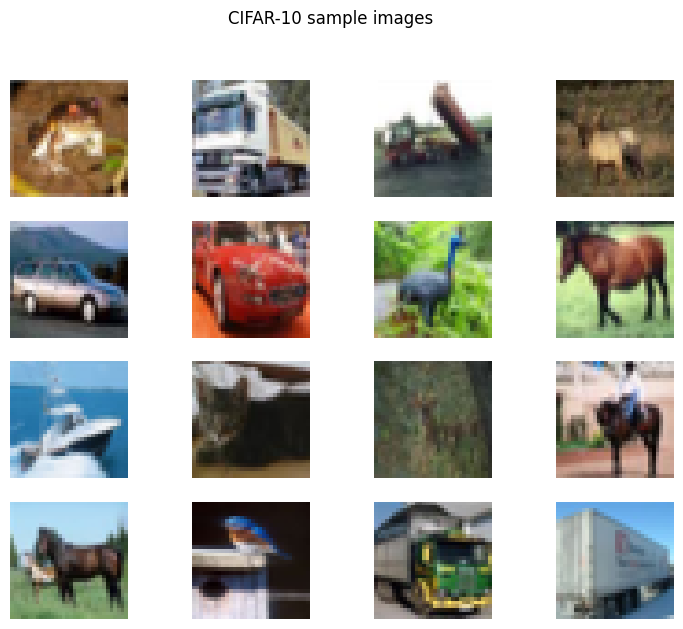

In [5]:
# Visualize
plt.figure(figsize = (9, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(train_images[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("CIFAR-10 sample images")
plt.axis('off')
plt.show()

# 3. preprocessing and cleaning

In [6]:
#將圖像值壓縮到0~1之間
def preprocess_images(images):
  images = images.reshape((images.shape[0], img_rows, img_cols, 3))/255.0
  datagen = ImageDataGenerator()
  datagen.fit(images)  
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [7]:
#打亂資料
train_size = len(train_images)
print("train images shape:",train_images.shape)
test_size = len(test_images)
print("test images shape:",test_images.shape)
batch_size = 64

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

train images shape: (50000, 32, 32, 3)
test images shape: (10000, 32, 32, 3)


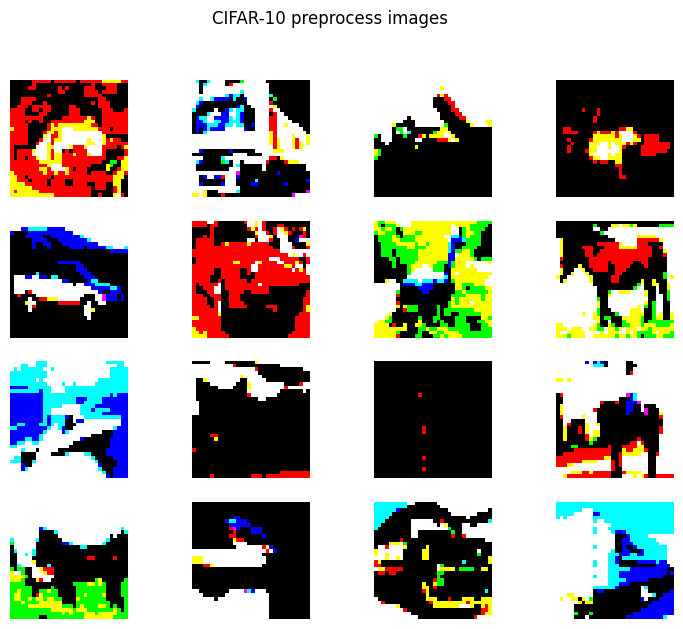

In [8]:
# Visualize preprocess images
plt.figure(figsize = (9, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(train_images[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("CIFAR-10 preprocess images")
plt.axis('off')
plt.show()

In [9]:
train_images[0].shape

(32, 32, 3)

# 4. VAE Model

In [10]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim = 100):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=train_images[0].shape),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=256, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units = 1024, activation = None),
            tf.keras.layers.Dense(units=4*4*32, activation=tf.nn.relu),#unit的數量8*8會影響到圖片大小，32是有幾個neurons
            tf.keras.layers.Reshape(target_shape=(4, 4, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=256, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same', activation = None),
        ]
    )

  @tf.function #Better performance
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape ,mean = 0.0, stddev = 1.0)
    return eps * tf.exp(logvar * 0.5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# 5. 訓練vae model 並顯示過程

In [12]:
epochs = 100
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 100
num_examples_to_generate = 16
# batch_size

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [13]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)

  # 畫出圖型
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, :] )
    plt.axis('off')
  
  # 存檔成png
  # tight_layout minimizes the overlap between 2 sub-plots
  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  

In [14]:
# Pick a sample of the test set for generating output imagesblank
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch : 100, Test set ELBO: -639.8441162109375, time elapse for current epoch: 8.624792098999023


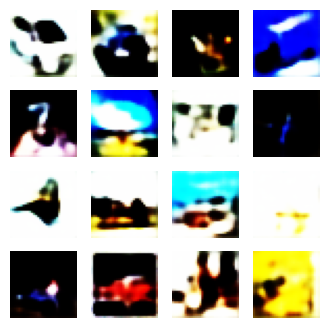

In [15]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch : {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [16]:
model.save_weights('conv_vae.h5')

# 6. 顯示訓練過程為gif

In [17]:
# anim_file = 'cvae.gif'

# with imageio.get_writer(anim_file, mode='I') as writer:
#   filenames = glob.glob('image*.png')
#   filenames = sorted(filenames)
#   for filename in filenames:
#     image = imageio.imread(filename)
#     writer.append_data(image)
#   image = imageio.imread(filename)
#   writer.append_data(image)

# import tensorflow_docs.vis.embed as embed
# embed.embed_file(anim_file)
# # 飛機、汽車、鳥、貓、鹿、狗、青蛙、馬、船和卡車


In [18]:

# !wget https://github.com/doudou030/AI_Learning_Exercise/blob/main/DL_Exercise/conv_vae.h5
# model = create_model()
# model = model.load_weights('conv_vae.h5')

# 7. IS and FID score
IS : Inception Score

https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/

---

FID : Fréchet inception distance

https://wandb.ai/authors/One-Shot-3D-Photography/reports/-Frechet-Inception-Distance-FID-GANs---Vmlldzo0MzI0MjA


In [19]:
mean, logvar = model.encode(test_sample)
z = model.reparameterize(mean, logvar)
predictions = model.sample(z)

# save to png
# for i in range(0,num_examples_to_generate):
#   plt.imshow(predictions[i, :, :, :] )
#   plt.axis('off')
#   plt.savefig('image_{}.png'.format(i))


In [20]:
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
 
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)
 
# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3()
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

In [21]:
print('loaded prediction', predictions.shape)
# calculate inception score
is_avg, is_std = calculate_inception_score(predictions)
print('prediction IS score', is_avg, is_std)


loaded prediction (16, 32, 32, 3)
1/1 [==============================] - 0s 25ms/step
prediction IS score 1.0 0.0


In [22]:
# calculate FID score
import math
from tqdm import tqdm, trange
BATCH_SIZE = 64
inception_model = tf.keras.applications.InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg')
def compute_embeddings(dataloader, count):
    image_embeddings = []

    for _ in tqdm(range(count)):
        images = next(iter(dataloader))
        images = tf.expand_dims(images, axis=0)
        images = tf.tile(images, [BATCH_SIZE, 3, 3, 1])
        # print(images.shape)
        embeddings = inception_model.predict(images)

        image_embeddings.extend(embeddings)

    return np.array(image_embeddings)

count = math.ceil(10000/6000)

# compute embeddings for real images
(trainloader, _), (_, _) = cifar10.load_data()
real_image_embeddings = compute_embeddings(trainloader, count)

# compute embeddings for generated images
generated_image_embeddings = compute_embeddings(predictions, count)

real_image_embeddings.shape, generated_image_embeddings.shape


  0%|          | 0/2 [00:00<?, ?it/s]

2/2 [==============================] - 2s 16ms/step


 50%|█████     | 1/2 [00:02<00:02,  2.43s/it]

2/2 [==============================] - 0s 12ms/step


  0%|          | 0/2 [00:00<?, ?it/s]

2/2 [==============================] - 1s 24ms/step


 50%|█████     | 1/2 [00:01<00:01,  1.61s/it]

2/2 [==============================] - 0s 24ms/step


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


((128, 2048), (128, 2048))

In [23]:
import numpy as np
from scipy.linalg import sqrtm

def calculate_fid(real_embeddings, generated_embeddings):
    # calculate mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
       covmean = covmean.real
     # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fid = calculate_fid(real_image_embeddings, generated_image_embeddings)

print("fid score is : ",fid)

fid score is :  2597963.0
